In [1]:
import sys
sys.path.append('../_amigocloud')

In [2]:
import simplekml

In [3]:
from amigocloud import AmigoCloud
import pandas as pd
from shapely import wkb

import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint
#from shapely.geometry import Point, MultiPoint
import os
#from fastkml import kml

In [4]:
# ruta de carpera donde estan las llaves
ruta = open('../ruta.txt')
ruta = ruta.readlines()[0]

In [5]:
# leer token
acceso = open(ruta + '/_keys/api_amigocloud.key','r')
api_token = acceso.readlines()[0]
acceso.close()
amigocloud = AmigoCloud(token=api_token)
amigocloud

In [7]:
# leer los dos shps de siembra y puntos de planificacion
path_siembras = r'C:\Documents\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\SHP\SIEMBRAS.shp'
path_cat = r'C:\Documents\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\SHP\catastro140624.shp'
path_puntos = r'C:\Documents\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\SHP\PUNTOS_PLAN.shp'

path_plan = r'C:\Documents\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\SHP\PLANIFICACION.shp'

path_kml = r'C:\Documents\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\KML_PLAN'

path_xlsx_parte = r'C:\Documents\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\PARTE DIARIO TRICHOGRAMMA 2024_RES.xlsx'

# ACTUALIZAR SHP PLANIFICACION

In [9]:
ors = 48

In [10]:
gdf_siembras = gpd.read_file(path_siembras)
gdf_puntos = gpd.read_file(path_puntos)
gdf_cat = gpd.read_file(path_cat)

In [11]:
# verifica si ambos shps tienen el mismo CRS
if gdf_siembras.crs == gdf_puntos.crs:
    print('Ambas capas tienen el mismo CRS')
else:
    print('No tienen el mismo CRS')

Ambas capas tienen el mismo CRS


In [12]:
# filtrar la semana de interes
gdf_puntos_select = gdf_puntos[gdf_puntos['os'] == ors]
gdf_puntos_sem = gdf_puntos_select.copy()
#quita caracteres especiales
gdf_puntos_sem['unidad_04'] = gdf_puntos_sem['unidad_04'].str.replace(r'[\r\n\t]', '', regex=True)
gdf_puntos_sem

,unidad_03,unidad_04,os,dia,obs,procesado,geometry
47,1171,BALCAZAR BALCAZAR ROQUE DAVID,48,0,NaN,NaN,"MULTIPOINT (468997.303 8096585.744, 469016.607..."
48,41819,AGROPECUARIA GUSTAVITO SRL,48,0,NaN,NaN,MULTIPOINT (463419.201 8082617.349)


In [13]:
multipoint_gdf = gdf_puntos_sem

In [14]:
# Crear una lista para almacenar los nuevos registros de puntos individuales
point_records = []
# Iterar sobre cada registro en el GeoDataFrame original
for idx, row in multipoint_gdf.iterrows():
    multipoint_geom = row.geometry
    # Verificar si la geometría es de tipo multipunto
    if isinstance(multipoint_geom, MultiPoint):
        for point in multipoint_geom.geoms:
            # Crear un nuevo registro para cada punto individual
            new_record = row.copy()
            new_record.geometry = point
            point_records.append(new_record)
    else:
        # Si la geometría ya es un punto, simplemente añadir el registro original
        point_records.append(row)

# Crear un nuevo GeoDataFrame con los registros de puntos individuales
puntos_indi = gpd.GeoDataFrame(point_records, crs=multipoint_gdf.crs)

In [15]:
# puntos individuales
puntos_indi

,unidad_03,unidad_04,os,dia,obs,procesado,geometry
47,1171,BALCAZAR BALCAZAR ROQUE DAVID,48,0,NaN,NaN,POINT (468997.303 8096585.744)
47,1171,BALCAZAR BALCAZAR ROQUE DAVID,48,0,NaN,NaN,POINT (469016.607 8096489.225)
47,1171,BALCAZAR BALCAZAR ROQUE DAVID,48,0,NaN,NaN,POINT (469095.367 8096493.858)
47,1171,BALCAZAR BALCAZAR ROQUE DAVID,48,0,NaN,NaN,POINT (469256.651 8096383.825)
47,1171,BALCAZAR BALCAZAR ROQUE DAVID,48,0,NaN,NaN,POINT (469472.396 8096002.302)
48,41819,AGROPECUARIA GUSTAVITO SRL,48,0,NaN,NaN,POINT (463419.201 8082617.349)


<Axes: >

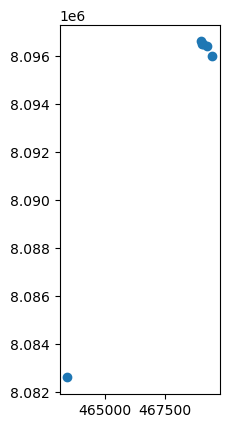

In [16]:
puntos_indi.plot()

In [18]:
# Asegurarse de que ambos GeoDataFrames tienen el mismo sistema de coordenadas (CRS)
if puntos_indi.crs != gdf_siembras.crs:
    print('Los CRS no son iguales')
    #gdf_siembras = gdf_siembras.to_crs(puntos_indi.crs)
else:
    print('Los CRS si son iguales')

Los CRS si son iguales


In [19]:
# Crear un GeoDataFrame vacío para almacenar los puntos que no intersectan con ningún polígono de siembras
puntos_indi_solicitado = puntos_indi[~puntos_indi.geometry.apply(lambda point: any(gdf_siembras.contains(point)))]

In [20]:
puntos_indi_solicitado

,unidad_03,unidad_04,os,dia,obs,procesado,geometry
47,1171,BALCAZAR BALCAZAR ROQUE DAVID,48,0,NaN,NaN,POINT (469016.607 8096489.225)


In [21]:
# identifoca los lotes que se intersectan
gdf_lotes_cat = gpd.sjoin(gdf_cat, puntos_indi_solicitado, how='inner', predicate='intersects')
# filtra los lotes intersectados en la capa original
poligonos_intersect_cat = gdf_cat.loc[gdf_cat.index.isin(gdf_lotes_cat.index)]
# copy
poligonos_intersect_cat = poligonos_intersect_cat.copy()
poligonos_intersect_cat = poligonos_intersect_cat[['unidad_01', 'unidad_02', 'unidad_03', 'unidad_04', 'unidad_05', 'area', 'soca', 'zona', 'geometry']]

In [22]:
# Cambiar el nombre de la columna 'old_name' a 'new_name'
poligonos_intersect_cat.rename(columns={'zona': 'inst'}, inplace=True)

In [23]:
poligonos_intersect_cat

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry
13385,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID,L8,0.448734,1,69,"POLYGON ((468984.252 8096493.979, 469000.916 8..."


In [24]:
# CAMBIAR NOMBRE DATOS DE UNIDAD_03 Y UNDIAD_04 DE LOTES SOLICITADOS A LO INDICADO EN LOS PUNTOS
# Iterar sobre cada punto y encontrar el polígono que intersecta
for idx, point in puntos_indi_solicitado.iterrows():
    point_geom = point.geometry
    matching_polygons = poligonos_intersect_cat[poligonos_intersect_cat.intersects(point_geom)]
    
    # Actualizar los campos de los polígonos que intersectan con los valores del punto
    for poly_idx in matching_polygons.index:
        poligonos_intersect_cat.at[poly_idx, 'unidad_03'] = point['unidad_03']
        poligonos_intersect_cat.at[poly_idx, 'unidad_04'] = point['unidad_04']

In [25]:
poligonos_intersect_cat

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry
13385,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID,L8,0.448734,1,69,"POLYGON ((468984.252 8096493.979, 469000.916 8..."


In [26]:
# agrega los campos faltantes
poligonos_intersect_cat['fecha_ini'] = ''
poligonos_intersect_cat['origen'] = 'SOLICITUD'
poligonos_intersect_cat['dias'] = 0
poligonos_intersect_cat['fecha'] = ''
poligonos_intersect_cat['os'] = ors

In [27]:
poligonos_intersect_cat

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry,fecha_ini,origen,dias,fecha,os
13385,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID,L8,0.448734,1,69,"POLYGON ((468984.252 8096493.979, 469000.916 8...",,SOLICITUD,0,,48


In [28]:
# SELECCIONAR LOS LOTES DE SIEMBRAS
# identifoca los lotes que se intersectan
gdf_lotes_siem = gpd.sjoin(gdf_siembras, multipoint_gdf, how='inner', predicate='intersects')
# filtra los lotes intersectados en la capa original
poligonos_intersect_siem = gdf_siembras.loc[gdf_siembras.index.isin(gdf_lotes_siem.index)]
# copy
poligonos_intersect_siem = poligonos_intersect_siem.copy()
# agregar campo de semana_planificacion
poligonos_intersect_siem['os'] = ors

In [29]:
# crea el campo soca, y coloca 0 o 1 dependiendo del origen
poligonos_intersect_siem['soca'] = poligonos_intersect_siem['origen'].apply(lambda x: 1 if 'SIEMBRA 2023' in x else 0)

In [30]:
poligonos_intersect_siem = poligonos_intersect_siem[['unidad_01', 'unidad_02', 'unidad_03', 'unidad_04', 'unidad_05', 'area',
       'fecha_ini', 'origen', 'dias', 'fecha', 'prioridad', 'inst', 'geometry', 'os', 'soca']]

In [31]:
poligonos_intersect_siem

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,fecha_ini,origen,dias,fecha,prioridad,inst,geometry,os,soca
257,458,RINCON DE GUENDA--CALLE,41819,AGROPECUARIA GUSTAVITO SRL,L7.1,3.330107,5/6/2024,SIEMBRA 2023,89.0,2024-05-06,7,304.0,"POLYGON ((463457.391 8082738.455, 463494.937 8...",48,1
489,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID,L2.1,1.070930,NaN,SIEMBRA 2023,0.0,NaN,1,69.0,"POLYGON ((469354.151 8096181.466, 469310.183 8...",48,1
579,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID,L5,2.698026,2024-04-29,SIEMBRA 2024,96.0,2024-04-29,1,0.0,"POLYGON ((469061.102 8096539.440, 469065.428 8...",48,0
586,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID,L6.4,1.365556,2024-04-25,SIEMBRA 2024,100.0,2024-04-25,1,0.0,"POLYGON ((469569.170 8096038.910, 469570.955 8...",48,0
603,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID,L3,2.902202,2024-04-29,SIEMBRA 2024,96.0,2024-04-29,1,0.0,"POLYGON ((469256.883 8096164.412, 469189.404 8...",48,0


In [32]:
# Concatenar los DataFrames a lo largo de las filas (axis=0)
plan = pd.concat([poligonos_intersect_cat, poligonos_intersect_siem], axis=0)
# Si deseas restablecer el índice después de concatenar
plan.reset_index(drop=True, inplace=True)

<Axes: >

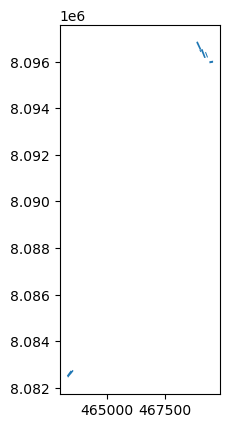

In [33]:
plan.plot()

In [34]:
plan['area'].sum()

11.815554816914

In [35]:
#RECALCULAR EL AREA
plan['area'] = plan.geometry.area / 10000

In [36]:
plan['area'].sum()

11.815554816915606

In [37]:
# carga el shp de planificacion
gdf_plan = gpd.read_file(path_plan)

In [38]:
# determina el ultimo id
last_id = 0
if gdf_plan['id'].max() > 0:
    last_id = gdf_plan['id'].max()
else:
    last_id = 0

In [39]:
last_id

408

In [40]:
# Asignar valores incrementales a la columna 'id' empezando desde last_id + 1
plan['id'] = range(last_id + 1, last_id + 1 + len(plan))

In [41]:
plan

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry,fecha_ini,origen,dias,fecha,os,prioridad,id
0,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID,L8,0.448734,1,69,"POLYGON ((468984.252 8096493.979, 469000.916 8...",,SOLICITUD,0.0,,48,NaN,409
1,458,RINCON DE GUENDA--CALLE,41819,AGROPECUARIA GUSTAVITO SRL,L7.1,3.330107,1,304.0,"POLYGON ((463457.391 8082738.455, 463494.937 8...",5/6/2024,SIEMBRA 2023,89.0,2024-05-06,48,7.0,410
2,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID,L2.1,1.070930,1,69.0,"POLYGON ((469354.151 8096181.466, 469310.183 8...",NaN,SIEMBRA 2023,0.0,NaN,48,1.0,411
3,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID,L5,2.698026,0,0.0,"POLYGON ((469061.102 8096539.440, 469065.428 8...",2024-04-29,SIEMBRA 2024,96.0,2024-04-29,48,1.0,412
4,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID,L6.4,1.365556,0,0.0,"POLYGON ((469569.170 8096038.910, 469570.955 8...",2024-04-25,SIEMBRA 2024,100.0,2024-04-25,48,1.0,413
5,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID,L3,2.902202,0,0.0,"POLYGON ((469256.883 8096164.412, 469189.404 8...",2024-04-29,SIEMBRA 2024,96.0,2024-04-29,48,1.0,414


In [42]:
len(plan)

6

In [43]:
# union de los dos gdf
gdf_pla_gral = pd.concat([gdf_plan, plan], ignore_index=True)

In [44]:
gdf_pla_gral['area'].sum()

3173.918389809103

In [45]:
gdf_pla_gral['unidad_01'] = gdf_pla_gral['unidad_01'].astype(int)
gdf_pla_gral['unidad_03'] = gdf_pla_gral['unidad_03'].astype(int)
gdf_pla_gral['dias'] = gdf_pla_gral['dias'].astype(int)
#gdf_pla_gral['prioridad'] = gdf_pla_gral['prioridad'].astype(int)
gdf_pla_gral['os'] = gdf_pla_gral['os'].astype(int)
gdf_pla_gral['soca'] = gdf_pla_gral['soca'].astype(int)
gdf_pla_gral['id'] = gdf_pla_gral['id'].astype(int)
gdf_pla_gral['inst'] = gdf_pla_gral['inst'].astype(int)

In [46]:
# exportar los datos en nuevo shp
gdf_pla_gral.to_file(path_plan)

In [47]:
gdf_pla_gral

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,fecha_ini,origen,dias,fecha,prioridad,os,soca,id,inst,telefono_1,telefono_2,telefono_3,idd,geometry
0,47,SANTA MARTHA,40149,PAZ REA JOSE ERNESTO,A7,10.696703,21/5/2024,SIEMBRA 2023,37,2024-05-21,1.0,26,1,1,69,0.0,0.0,NaN,35,"POLYGON ((488616.298 8103763.516, 488519.488 8..."
1,187,MATIAS--HABBAUER,5421,HUBBAUER HOYOS ENRIQUE,L7.2,1.835936,2024-04-15,SIEMBRA 2024,73,2024-04-15,6.0,26,0,2,62,0.0,0.0,NaN,54,"POLYGON ((473330.370 8101634.734, 473440.011 8..."
2,187,MATIAS--HABBAUER,5421,HUBBAUER HOYOS ENRIQUE,L6,1.960231,2024-04-15,SIEMBRA 2024,73,2024-04-15,6.0,26,0,3,62,0.0,0.0,NaN,54,"POLYGON ((473242.172 8101427.289, 473148.580 8..."
3,187,MATIAS--HABBAUER,5421,HUBBAUER HOYOS ENRIQUE,L9.1,3.607907,2024-04-16,SIEMBRA 2024,72,2024-04-16,6.0,26,0,4,62,0.0,0.0,NaN,54,"POLYGON ((473286.579 8101086.503, 473265.875 8..."
4,2123,LAS CHACRAS PORTACHUELO,13132,ZUMARAN MENACHO JORGE,L1.6,0.386826,2024-04-22,SIEMBRA 2024,66,2024-04-22,10.0,26,0,5,50,0.0,0.0,NaN,63,"POLYGON ((455236.898 8084312.120, 455248.807 8..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391,458,RINCON DE GUENDA--CALLE,41819,AGROPECUARIA GUSTAVITO SRL,L7.1,3.330107,5/6/2024,SIEMBRA 2023,89,2024-05-06,7.0,48,1,410,304,NaN,NaN,NaN,NaN,"POLYGON ((463457.391 8082738.455, 463494.937 8..."
392,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID,L2.1,1.070930,NaN,SIEMBRA 2023,0,NaN,1.0,48,1,411,69,NaN,NaN,NaN,NaN,"POLYGON ((469354.151 8096181.466, 469310.183 8..."
393,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID,L5,2.698026,2024-04-29,SIEMBRA 2024,96,2024-04-29,1.0,48,0,412,0,NaN,NaN,NaN,NaN,"POLYGON ((469061.102 8096539.440, 469065.428 8..."
394,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID,L6.4,1.365556,2024-04-25,SIEMBRA 2024,100,2024-04-25,1.0,48,0,413,0,NaN,NaN,NaN,NaN,"POLYGON ((469569.170 8096038.910, 469570.955 8..."


# CARGAR PLANIFICACION A AMIGOCLOUD

In [48]:
def convertir_a_multipolygon(geometry):
    if isinstance(geometry, Polygon):
        return MultiPolygon([geometry])
    return geometry

def convertir_a_wkb(polygon):
    wkb_data = wkb.dumps(polygon, hex=True)
    return wkb_data

In [49]:
# repreyectar a WGS84
gdf_pla_gral = plan.to_crs(epsg=4326)
# convertir poligonos a multipoligonos
gdf_pla_gral['geometry'] = gdf_pla_gral['geometry'].apply(convertir_a_multipolygon)

In [50]:
gdf_pla_gral['unidad_01'] = gdf_pla_gral['unidad_01'].astype(int)
gdf_pla_gral['unidad_03'] = gdf_pla_gral['unidad_03'].astype(int)
gdf_pla_gral['dias'] = gdf_pla_gral['dias'].astype(int)
#gdf_pla_gral['prioridad'] = gdf_pla_gral['prioridad'].astype(int)
gdf_pla_gral['os'] = gdf_pla_gral['os'].astype(int)
gdf_pla_gral['soca'] = gdf_pla_gral['soca'].astype(int)
gdf_pla_gral['id'] = gdf_pla_gral['id'].astype(int)
gdf_pla_gral['inst'] = gdf_pla_gral['inst'].astype(int)

In [51]:
len(gdf_pla_gral)

6

In [52]:
# recorrer el gdf de lotes y cargarlo a amigocloud
id_proyecto = f'https://app.amigocloud.com/api/v1/projects/33457/sql'
for index, row in gdf_pla_gral.iterrows():
    wkb_hex = convertir_a_wkb(row['geometry'])
    insert_sql = f"""
    INSERT INTO dataset_345601 (id, unidad_01, unidad_02, unidad_03, unidad_04, unidad_05, area, origen, dias, os, geometry)
    VALUES ({row['id']}, {row['unidad_01']}, '{row['unidad_02']}', {row['unidad_03']}, '{row['unidad_04']}', '{row['unidad_05']}', {row['area']}, '{row['origen']}', '{row['dias']}', '{row['os']}', ST_SetSRID(ST_GeomFromWKB('\\x{wkb_hex}'), 4326));
    """
    query_sql = {'query': insert_sql}
    resultado_post = amigocloud.post(id_proyecto, query_sql)

# CREAR KMLS DE PLANIFICACION

In [53]:
gdf_plan = gpd.read_file(path_plan)

In [54]:
gdf_plan_sem = gdf_plan[gdf_plan['os'] == ors]
gdf_plan_sem['area'].sum()

11.815554816915608

In [55]:
lista_cods = list(set(gdf_plan_sem['unidad_01']))

In [56]:
lista_cods

[369, 458]

In [57]:
for i in lista_cods:
    prop = gdf_plan_sem[gdf_plan_sem['unidad_01'] == i]
    prop_wgs = prop.to_crs(epsg=4326)
    output_folder = path_kml + '\\' + str(i)
    print(output_folder)
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    # Recorrer el GeoDataFrame
    for idx, row in prop_wgs.iterrows():
        # Crear un nuevo documento KML
        kml_doc = simplekml.Kml()
        # Obtener el polígono y el nombre
        polygon = row['geometry']
        name = row['unidad_05']
        # Convertir el polígono en una lista de coordenadas
        coords = [(x, y) for x, y in zip(*polygon.exterior.xy)]    
        # Añadir el polígono al documento KML
        pol = kml_doc.newpolygon(name=name, outerboundaryis=coords)
        # Guardar el archivo KML
        file_name = f"{name}.kml"
        output_path = os.path.join(output_folder, file_name)
        kml_doc.save(output_path)

C:\Documents\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\KML_PLAN\369
C:\Documents\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2024\KML_PLAN\458


# CARGAR XLSX

In [58]:
from openpyxl import load_workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from datetime import datetime

In [59]:
# Cargar el archivo Excel
sheet_name = 'DATA'
table_name = 'tbl_data'

In [60]:
excel_data = pd.read_excel(path_xlsx_parte)

In [61]:
gdf_pla_gral

,unidad_01,unidad_02,unidad_03,unidad_04,unidad_05,area,soca,inst,geometry,fecha_ini,origen,dias,fecha,os,prioridad,id
0,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID,L8,0.448734,1,69,"MULTIPOLYGON (((-63.29172 -17.21629, -63.29156...",,SOLICITUD,0,,48,NaN,409
1,458,RINCON DE GUENDA--CALLE,41819,AGROPECUARIA GUSTAVITO SRL,L7.1,3.330107,1,304,"MULTIPOLYGON (((-63.34393 -17.34055, -63.34358...",5/6/2024,SIEMBRA 2023,89,2024-05-06,48,7.0,410
2,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID,L2.1,1.070930,1,69,"MULTIPOLYGON (((-63.28824 -17.21912, -63.28866...",NaN,SIEMBRA 2023,0,NaN,48,1.0,411
3,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID,L5,2.698026,0,0,"MULTIPOLYGON (((-63.29100 -17.21588, -63.29095...",2024-04-29,SIEMBRA 2024,96,2024-04-29,48,1.0,412
4,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID,L6.4,1.365556,0,0,"MULTIPOLYGON (((-63.28622 -17.22041, -63.28621...",2024-04-25,SIEMBRA 2024,100,2024-04-25,48,1.0,413
5,369,TOBOROCHI--BALCAZAR,1171,BALCAZAR BALCAZAR ROQUE DAVID,L3,2.902202,0,0,"MULTIPOLYGON (((-63.28916 -17.21928, -63.28979...",2024-04-29,SIEMBRA 2024,96,2024-04-29,48,1.0,414


In [62]:
list(gdf_pla_gral['unidad_01'])

[369, 458, 369, 369, 369, 369]

In [63]:
new_data = {
    'INSTITUCION':list(gdf_pla_gral['inst']), 
    'COD CANERO': list(gdf_pla_gral['unidad_03']),
    'NOMBRE CANERO': list(gdf_pla_gral['unidad_04']),
    'COD PROPIEDAD': list(gdf_pla_gral['unidad_01']),
    'NOMBRE PROPIEDAD': list(gdf_pla_gral['unidad_02']),
    'LOTE': list(gdf_pla_gral['unidad_05']),
    'HECTAREA': list(gdf_pla_gral['area']),
    'CICLO': list(gdf_pla_gral['soca']),
    'FINANCIADO': list(gdf_pla_gral['origen']),
    'ID': list(gdf_pla_gral['id']),
    'OS': list(gdf_pla_gral['os'])
}

new_df = pd.DataFrame(new_data)

In [64]:
new_df['PRODUCTO'] = 'TRICHOGRAMMA'
new_df['DOSIS'] = '6ml'

In [65]:
new_df

,INSTITUCION,COD CANERO,NOMBRE CANERO,COD PROPIEDAD,NOMBRE PROPIEDAD,LOTE,HECTAREA,CICLO,FINANCIADO,ID,OS,PRODUCTO,DOSIS
0,69,1171,BALCAZAR BALCAZAR ROQUE DAVID,369,TOBOROCHI--BALCAZAR,L8,0.448734,1,SOLICITUD,409,48,TRICHOGRAMMA,6ml
1,304,41819,AGROPECUARIA GUSTAVITO SRL,458,RINCON DE GUENDA--CALLE,L7.1,3.330107,1,SIEMBRA 2023,410,48,TRICHOGRAMMA,6ml
2,69,1171,BALCAZAR BALCAZAR ROQUE DAVID,369,TOBOROCHI--BALCAZAR,L2.1,1.070930,1,SIEMBRA 2023,411,48,TRICHOGRAMMA,6ml
3,0,1171,BALCAZAR BALCAZAR ROQUE DAVID,369,TOBOROCHI--BALCAZAR,L5,2.698026,0,SIEMBRA 2024,412,48,TRICHOGRAMMA,6ml
4,0,1171,BALCAZAR BALCAZAR ROQUE DAVID,369,TOBOROCHI--BALCAZAR,L6.4,1.365556,0,SIEMBRA 2024,413,48,TRICHOGRAMMA,6ml
5,0,1171,BALCAZAR BALCAZAR ROQUE DAVID,369,TOBOROCHI--BALCAZAR,L3,2.902202,0,SIEMBRA 2024,414,48,TRICHOGRAMMA,6ml


In [66]:
final_data = pd.concat([excel_data, new_df], ignore_index=True)

In [67]:
final_data.to_excel(path_xlsx_parte, index=False)